# Unit05_Gaussian_Mixture_Models | 高斯混合模型：反應器多產品品質分布建模

本 Notebook 使用 `Part_2/Unit05/data/reactor_simulation/multi_product_quality.csv` 建立高斯混合模型 (GMM) 來分析反應器多產品品質分布，識別不同品質等級並提供機率評估。

## 目標
- 理解 GMM 的核心原理與 EM 演算法
- 學會使用不同協方差類型的 GMM 模型
- 掌握 GMM 的軟分群與機率評估特性
- 應用於反應器多產品品質分布建模
- 比較 GMM 與 K-Means 的差異

資料背景：模擬反應器生產三種不同品質等級產品的數據，包含產率、純度、選擇性等品質指標。

---
### 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit05_Gaussian_Mixture_Models'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit05'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Gaussian_Mixture_Models
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Gaussian_Mixture_Models\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Gaussian_Mixture_Models\figs


In [2]:
# 載入相關套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, confusion_matrix
)
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
np.random.seed(42)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 所有套件載入完成")

✓ 所有套件載入完成


---
## 1. 數據生成與探索性數據分析 (EDA)

### 1.1 生成模擬數據

模擬反應器生產三種不同品質等級產品的數據：
- **優良品 (Premium)**：高產率、高純度、高選擇性
- **合格品 (Standard)**：中產率、中純度、中選擇性
- **次級品 (Substandard)**：低產率、低純度、低選擇性

**數據複雜度設計**：
- 群集間的均值距離較小，增加重疊區域
- 協方差矩陣具有較強的特徵相關性
- 不同群集的形狀和大小差異明顯
- 使 GMM 的軟分群優勢更加突出

In [3]:
# 生成模擬數據 (增加群集重疊與複雜度)
np.random.seed(42)

# === 優良品 (Premium) ===
# 縮小均值差距，增加與 Standard 的重疊
n_premium = 200
mean_premium = [78, 88, 82]  # [產率%, 純度%, 選擇性%] - 降低均值
cov_premium = [[20, 8, -5],   # 增加協方差，使分布更分散
               [8, 15, 6],
               [-5, 6, 18]]
X_premium = np.random.multivariate_normal(mean_premium, cov_premium, n_premium)
y_premium = np.zeros(n_premium, dtype=int)

# === 合格品 (Standard) ===
# 調整均值與協方差，增加與 Premium 和 Substandard 的重疊
n_standard = 300
mean_standard = [68, 78, 72]  # 提高均值，接近 Premium
cov_standard = [[25, -8, 10],  # 增加協方差複雜度
                [-8, 18, -5],
                [10, -5, 22]]
X_standard = np.random.multivariate_normal(mean_standard, cov_standard, n_standard)
y_standard = np.ones(n_standard, dtype=int)

# === 次級品 (Substandard) ===
# 提高均值，增加與 Standard 的重疊
n_substandard = 150
mean_substandard = [58, 68, 65]  # 提高均值
cov_substandard = [[30, 12, -8],  # 增加方差與相關性
                   [12, 22, 7],
                   [-8, 7, 25]]
X_substandard = np.random.multivariate_normal(mean_substandard, cov_substandard, n_substandard)
y_substandard = np.full(n_substandard, 2, dtype=int)

# === 合併數據 ===
X = np.vstack([X_premium, X_standard, X_substandard])
y_true = np.concatenate([y_premium, y_standard, y_substandard])

# === 建立 DataFrame ===
df = pd.DataFrame(X, columns=['Yield', 'Purity', 'Selectivity'])
df['True_Label'] = y_true
df['Quality_Level'] = df['True_Label'].map({0: 'Premium', 1: 'Standard', 2: 'Substandard'})

# 儲存數據
DATA_DIR.mkdir(parents=True, exist_ok=True)
df.to_csv(DATA_DIR / 'multi_product_quality.csv', index=False)

print("✓ 模擬數據生成完成")
print(f"\n數據形狀: {df.shape}")
print(f"\n品質等級分布:")
print(df['Quality_Level'].value_counts())
print(f"\n數據統計摘要:")
print(df.describe())

✓ 模擬數據生成完成

數據形狀: (650, 5)

品質等級分布:
Quality_Level
Standard       300
Premium        200
Substandard    150
Name: count, dtype: int64

數據統計摘要:
            Yield      Purity  Selectivity  True_Label
count  650.000000  650.000000   650.000000  650.000000
mean    68.142001   78.792402    73.471737    0.923077
std      8.901615    8.506684     7.975838    0.730318
min     46.309318   56.062210    50.497266    0.000000
25%     61.977313   72.596814    67.458394    0.000000
50%     68.240014   79.020003    72.948125    1.000000
75%     75.495468   85.920487    79.420892    1.000000
max     87.815974   98.572909    94.043591    2.000000


### 1.2 探索性數據分析

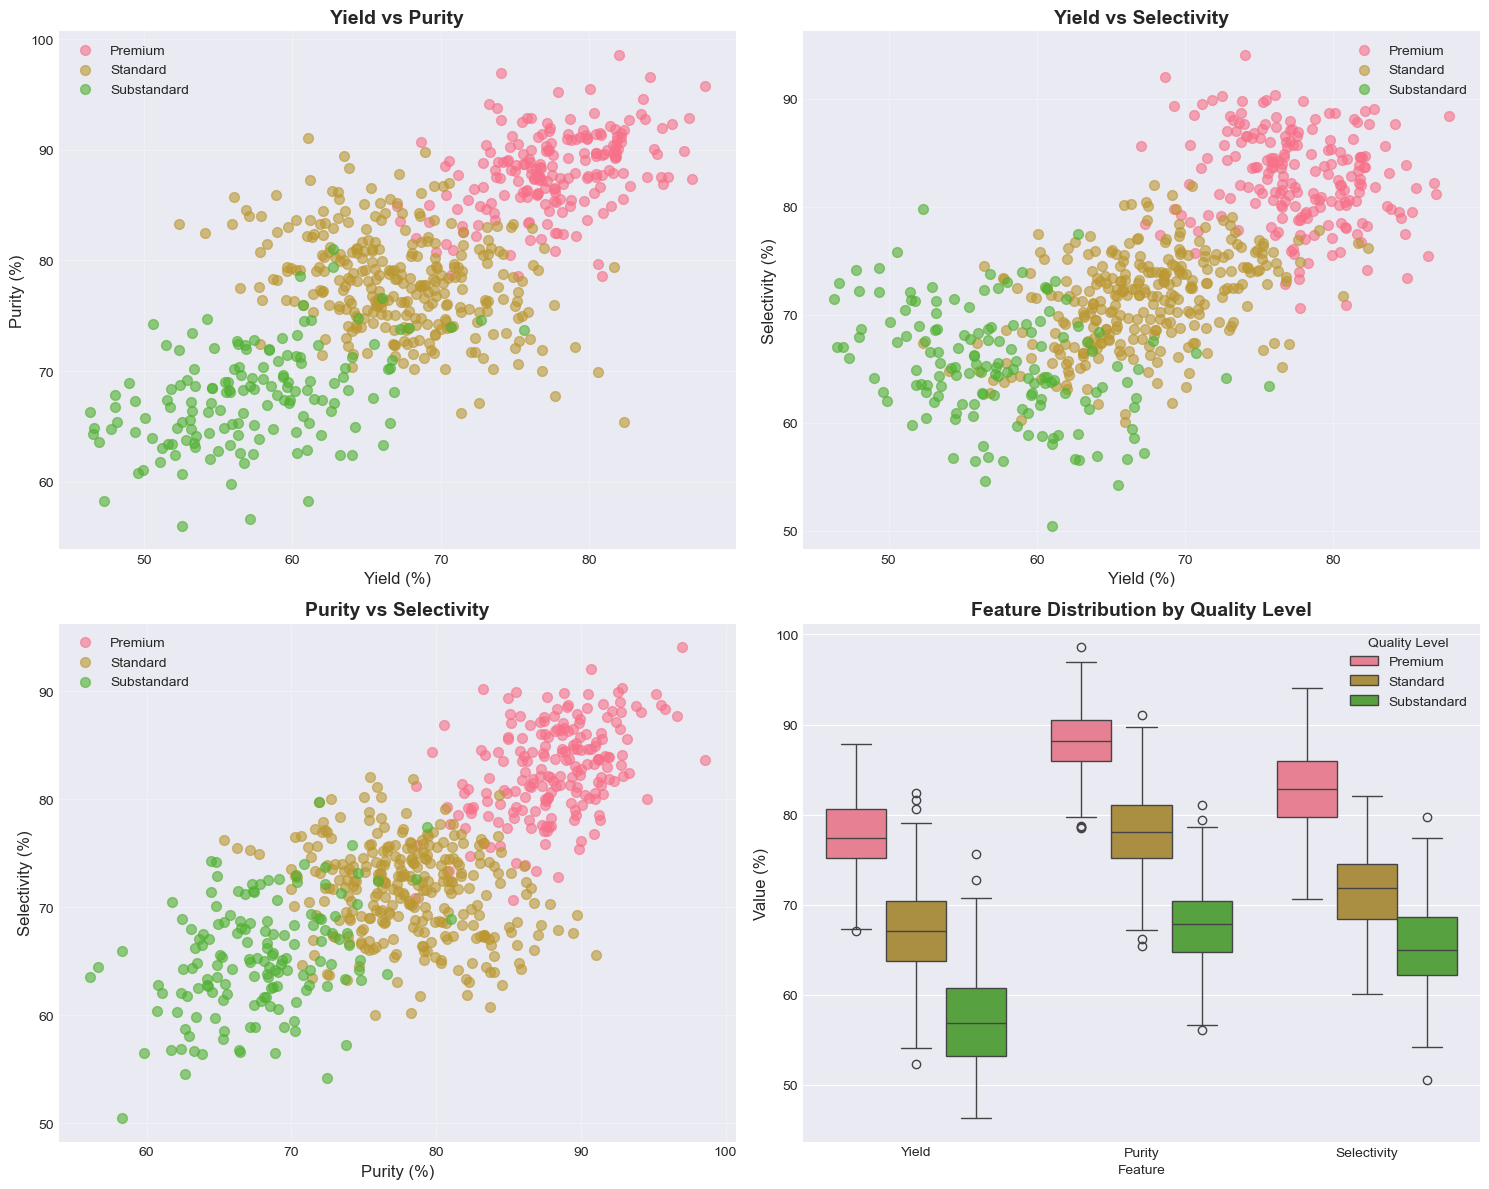

✓ 數據探索視覺化完成


In [4]:
# 數據視覺化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 散點圖矩陣 (Pairplot-style)
features = ['Yield', 'Purity', 'Selectivity']
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y_true]

scatter_pairs = [(0, 1), (0, 2), (1, 2)]
titles = ['Yield vs Purity', 'Yield vs Selectivity', 'Purity vs Selectivity']

for idx, (i, j) in enumerate(scatter_pairs):
    ax = axes[idx // 2, idx % 2]
    for quality_label, quality_name in enumerate(['Premium', 'Standard', 'Substandard']):
        mask = y_true == quality_label
        ax.scatter(
            X[mask, i], X[mask, j],
            label=quality_name, alpha=0.6, s=50
        )
    ax.set_xlabel(f'{features[i]} (%)', fontsize=12)
    ax.set_ylabel(f'{features[j]} (%)', fontsize=12)
    ax.set_title(titles[idx], fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 2. 箱型圖
ax = axes[1, 1]
df_melted = df[features + ['Quality_Level']].melt(
    id_vars='Quality_Level',
    var_name='Feature',
    value_name='Value'
)
sns.boxplot(data=df_melted, x='Feature', y='Value', hue='Quality_Level', ax=ax)
ax.set_title('Feature Distribution by Quality Level', fontsize=14, fontweight='bold')
ax.set_ylabel('Value (%)', fontsize=12)
ax.legend(title='Quality Level')

plt.tight_layout()
plt.savefig(FIG_DIR / '01_data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 數據探索視覺化完成")

---
## 2. 數據預處理

### 2.1 特徵標準化

In [5]:
# 特徵標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ 特徵標準化完成")
print(f"\n標準化後的數據統計:")
print(f"均值: {X_scaled.mean(axis=0)}")
print(f"標準差: {X_scaled.std(axis=0)}")

✓ 特徵標準化完成

標準化後的數據統計:
均值: [-1.64654615e-16 -3.84649577e-15 -1.77635684e-17]
標準差: [1. 1. 1.]


---
## 3. 選擇最佳群集數量 K

### 3.1 使用 BIC, AIC 和輪廓係數選擇 K

In [6]:
# 評估不同 K 值的模型
K_range = range(2, 8)
results = {
    'K': [],
    'BIC': [],
    'AIC': [],
    'Log_Likelihood': [],
    'Silhouette': [],
    'DB_Index': [],
    'CH_Index': []
}

for K in K_range:
    print(f"評估 K = {K}...")
    
    # 訓練 GMM 模型
    gmm = GaussianMixture(
        n_components=K,
        covariance_type='full',
        n_init=10,
        max_iter=100,
        random_state=42
    )
    gmm.fit(X_scaled)
    
    # 預測標籤
    labels = gmm.predict(X_scaled)
    
    # 計算各種指標
    results['K'].append(K)
    results['BIC'].append(gmm.bic(X_scaled))
    results['AIC'].append(gmm.aic(X_scaled))
    results['Log_Likelihood'].append(gmm.score(X_scaled))
    results['Silhouette'].append(silhouette_score(X_scaled, labels))
    results['DB_Index'].append(davies_bouldin_score(X_scaled, labels))
    results['CH_Index'].append(calinski_harabasz_score(X_scaled, labels))

print("\n✓ K 值評估完成")

評估 K = 2...
評估 K = 3...
評估 K = 4...
評估 K = 5...
評估 K = 6...
評估 K = 7...

✓ K 值評估完成


### 3.2 視覺化評估指標

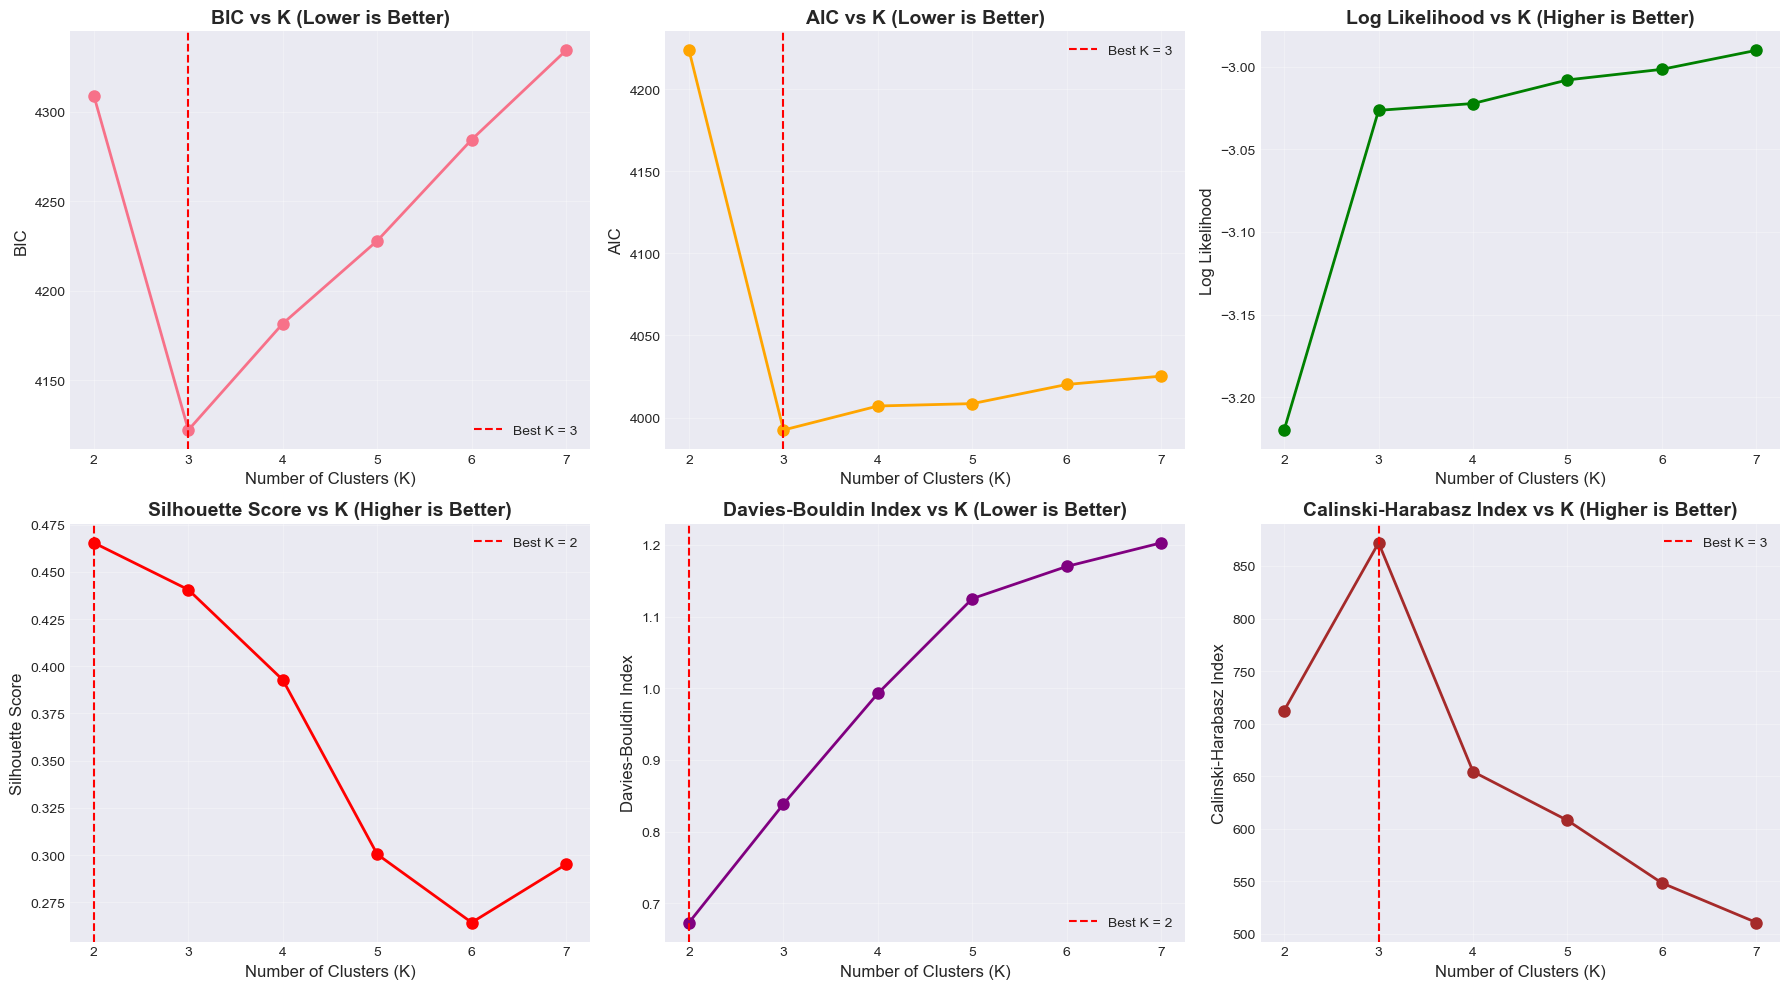


最佳 K 值 (基於 BIC): 3
最佳 K 值 (基於 AIC): 3
最佳 K 值 (基於 Silhouette): 2


In [7]:
# 視覺化評估指標
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# BIC
axes[0, 0].plot(results['K'], results['BIC'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('BIC', fontsize=12)
axes[0, 0].set_title('BIC vs K (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
best_k_bic = results['K'][np.argmin(results['BIC'])]
axes[0, 0].axvline(best_k_bic, color='red', linestyle='--', label=f'Best K = {best_k_bic}')
axes[0, 0].legend()

# AIC
axes[0, 1].plot(results['K'], results['AIC'], marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('AIC', fontsize=12)
axes[0, 1].set_title('AIC vs K (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
best_k_aic = results['K'][np.argmin(results['AIC'])]
axes[0, 1].axvline(best_k_aic, color='red', linestyle='--', label=f'Best K = {best_k_aic}')
axes[0, 1].legend()

# Log Likelihood
axes[0, 2].plot(results['K'], results['Log_Likelihood'], marker='o', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 2].set_ylabel('Log Likelihood', fontsize=12)
axes[0, 2].set_title('Log Likelihood vs K (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Silhouette Score
axes[1, 0].plot(results['K'], results['Silhouette'], marker='o', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 0].set_title('Silhouette Score vs K (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
best_k_sil = results['K'][np.argmax(results['Silhouette'])]
axes[1, 0].axvline(best_k_sil, color='red', linestyle='--', label=f'Best K = {best_k_sil}')
axes[1, 0].legend()

# Davies-Bouldin Index
axes[1, 1].plot(results['K'], results['DB_Index'], marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Index vs K (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
best_k_db = results['K'][np.argmin(results['DB_Index'])]
axes[1, 1].axvline(best_k_db, color='red', linestyle='--', label=f'Best K = {best_k_db}')
axes[1, 1].legend()

# Calinski-Harabasz Index
axes[1, 2].plot(results['K'], results['CH_Index'], marker='o', linewidth=2, markersize=8, color='brown')
axes[1, 2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 2].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 2].set_title('Calinski-Harabasz Index vs K (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
best_k_ch = results['K'][np.argmax(results['CH_Index'])]
axes[1, 2].axvline(best_k_ch, color='red', linestyle='--', label=f'Best K = {best_k_ch}')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / '02_K_selection_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n最佳 K 值 (基於 BIC): {best_k_bic}")
print(f"最佳 K 值 (基於 AIC): {best_k_aic}")
print(f"最佳 K 值 (基於 Silhouette): {best_k_sil}")

---
## 4. 訓練最佳 GMM 模型

### 4.1 使用最佳 K 值訓練模型

In [8]:
# 使用最佳 K 值訓練最終模型
best_K = best_k_bic  # 使用 BIC 選擇的最佳 K 值

gmm_best = GaussianMixture(
    n_components=best_K,
    covariance_type='full',
    n_init=10,
    max_iter=100,
    random_state=42
)

gmm_best.fit(X_scaled)

# 預測結果
labels_pred = gmm_best.predict(X_scaled)
proba_pred = gmm_best.predict_proba(X_scaled)

print(f"✓ 最佳 GMM 模型訓練完成 (K = {best_K})")
print(f"\n模型資訊:")
print(f"收斂狀態: {gmm_best.converged_}")
print(f"迭代次數: {gmm_best.n_iter_}")
print(f"對數似然: {gmm_best.score(X_scaled):.4f}")
print(f"BIC: {gmm_best.bic(X_scaled):.4f}")
print(f"AIC: {gmm_best.aic(X_scaled):.4f}")
print(f"\n混合係數 (權重): {gmm_best.weights_}")

# 儲存模型
import joblib
joblib.dump(gmm_best, MODEL_DIR / 'gmm_best_model.pkl')
joblib.dump(scaler, MODEL_DIR / 'scaler.pkl')
print(f"\n✓ 模型已儲存至: {MODEL_DIR}")

✓ 最佳 GMM 模型訓練完成 (K = 3)

模型資訊:
收斂狀態: True
迭代次數: 3
對數似然: -3.0265
BIC: 4122.2502
AIC: 3992.4180

混合係數 (權重): [0.47641864 0.22163558 0.30194578]

✓ 模型已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Gaussian_Mixture_Models\models


---
## 5. 模型視覺化與分析

### 5.1 硬分群 vs 軟分群視覺化

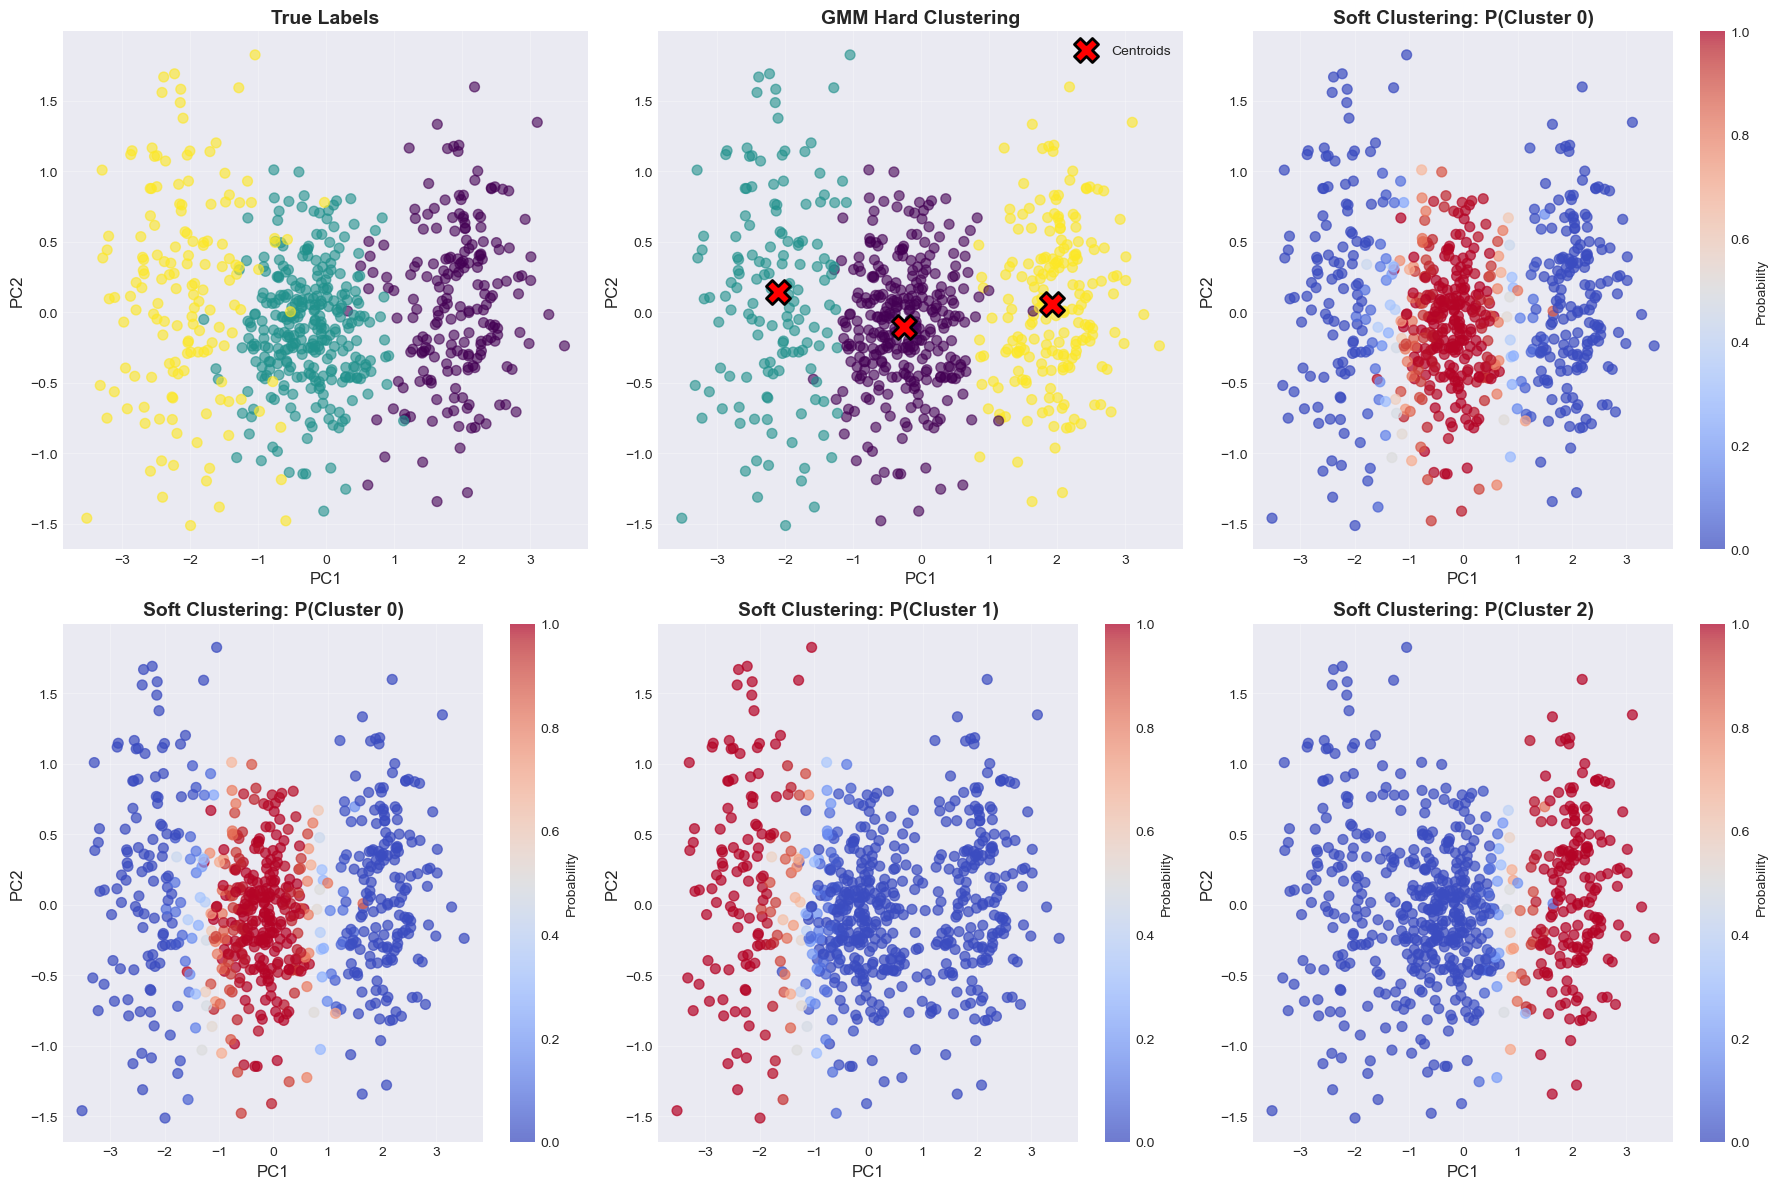

✓ 硬分群與軟分群視覺化完成


In [9]:
# 視覺化硬分群與軟分群結果
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 使用 PCA 降維到 2D 以便視覺化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 恢復原始尺度的群集中心
means_original = scaler.inverse_transform(gmm_best.means_)

# 1. 真實標籤
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('True Labels', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. GMM 硬分群
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, cmap='viridis', alpha=0.6, s=50)
means_pca = pca.transform(gmm_best.means_)
axes[0, 1].scatter(means_pca[:, 0], means_pca[:, 1], 
                   marker='X', s=300, c='red', edgecolors='black', 
                   label='Centroids', linewidths=2)
axes[0, 1].set_xlabel('PC1', fontsize=12)
axes[0, 1].set_ylabel('PC2', fontsize=12)
axes[0, 1].set_title('GMM Hard Clustering', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. GMM 軟分群 - Cluster 0 機率
scatter = axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=proba_pred[:, 0], cmap='coolwarm', 
                             alpha=0.7, s=50, vmin=0, vmax=1)
axes[0, 2].set_xlabel('PC1', fontsize=12)
axes[0, 2].set_ylabel('PC2', fontsize=12)
axes[0, 2].set_title(f'Soft Clustering: P(Cluster 0)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 2], label='Probability')
axes[0, 2].grid(True, alpha=0.3)

# 4-6. 各群集的軟分群機率
for i in range(min(3, best_K)):
    row = 1
    col = i
    scatter = axes[row, col].scatter(X_pca[:, 0], X_pca[:, 1], 
                                     c=proba_pred[:, i], cmap='coolwarm', 
                                     alpha=0.7, s=50, vmin=0, vmax=1)
    axes[row, col].set_xlabel('PC1', fontsize=12)
    axes[row, col].set_ylabel('PC2', fontsize=12)
    axes[row, col].set_title(f'Soft Clustering: P(Cluster {i})', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=axes[row, col], label='Probability')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '03_hard_soft_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 硬分群與軟分群視覺化完成")

### 5.2 橢圓形群集視覺化

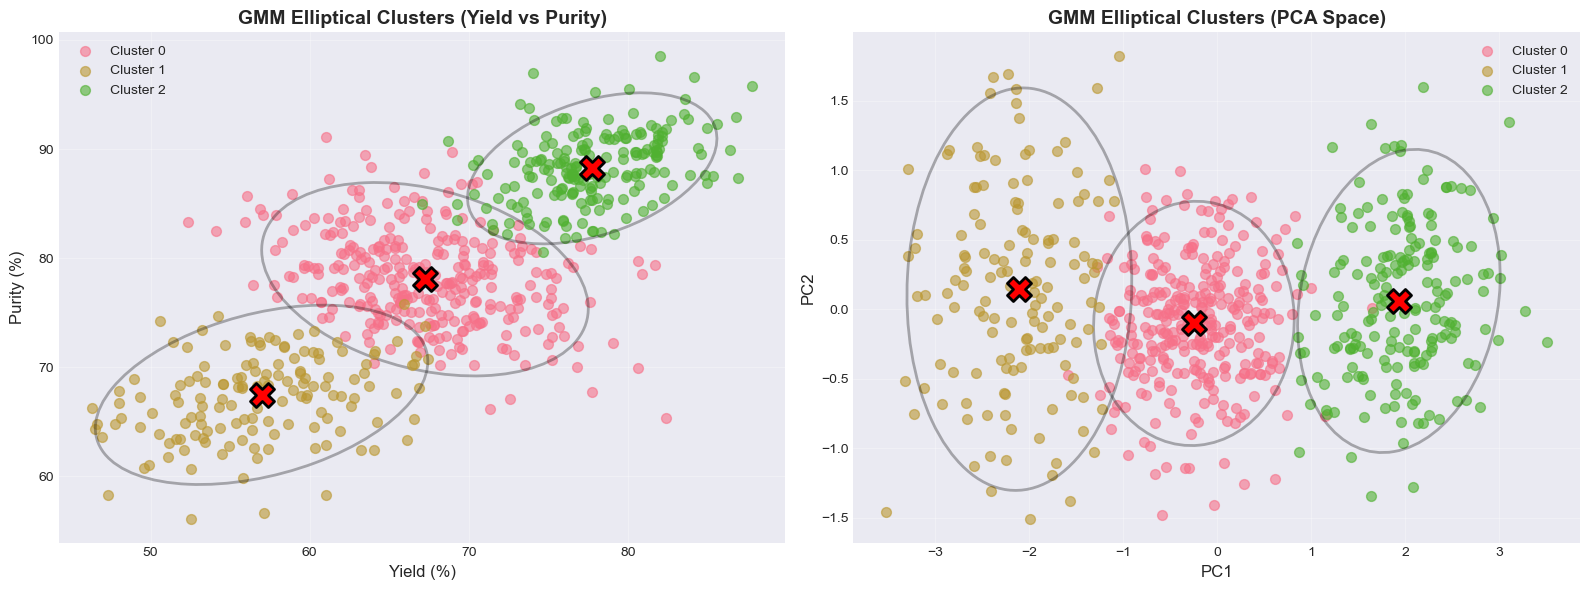

✓ 橢圓形群集視覺化完成


In [10]:
# 繪製橢圓形群集 (使用前兩個特徵)
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, **kwargs):
    """繪製協方差橢圓"""
    # 計算特徵值和特徵向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    
    # 計算橢圓的角度
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
    # 計算橢圓的寬度和高度 (2倍標準差)
    width, height = 2 * 2 * np.sqrt(eigenvalues)
    
    # 繪製橢圓
    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：使用原始特徵 (Yield vs Purity)
ax = axes[0]
for i in range(best_K):
    mask = labels_pred == i
    ax.scatter(X[mask, 0], X[mask, 1], alpha=0.6, s=50, label=f'Cluster {i}')
    
    # 繪製群集中心
    ax.scatter(means_original[i, 0], means_original[i, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidths=2)
    
    # 繪製協方差橢圓
    cov_2d = gmm_best.covariances_[i][:2, :2]
    cov_2d_original = scaler.scale_[:2, np.newaxis] * cov_2d * scaler.scale_[:2]
    draw_ellipse(means_original[i, :2], cov_2d_original, ax, 
                 alpha=0.3, edgecolor='black', linewidth=2, facecolor='none')

ax.set_xlabel('Yield (%)', fontsize=12)
ax.set_ylabel('Purity (%)', fontsize=12)
ax.set_title('GMM Elliptical Clusters (Yield vs Purity)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 右圖：使用 PCA 降維後的特徵
ax = axes[1]
for i in range(best_K):
    mask = labels_pred == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.6, s=50, label=f'Cluster {i}')
    
    # 繪製群集中心
    ax.scatter(means_pca[i, 0], means_pca[i, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidths=2)
    
    # PCA 空間中的協方差
    cov_pca = pca.components_ @ gmm_best.covariances_[i] @ pca.components_.T
    draw_ellipse(means_pca[i], cov_pca, ax, 
                 alpha=0.3, edgecolor='black', linewidth=2, facecolor='none')

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title('GMM Elliptical Clusters (PCA Space)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '04_elliptical_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 橢圓形群集視覺化完成")

---
## 6. GMM vs K-Means 比較

### 6.1 訓練 K-Means 模型進行比較

In [11]:
# 訓練 K-Means 模型
kmeans = KMeans(n_clusters=best_K, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# 比較評估指標
sil_gmm = silhouette_score(X_scaled, labels_pred)
sil_kmeans = silhouette_score(X_scaled, labels_kmeans)

db_gmm = davies_bouldin_score(X_scaled, labels_pred)
db_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)

ch_gmm = calinski_harabasz_score(X_scaled, labels_pred)
ch_kmeans = calinski_harabasz_score(X_scaled, labels_kmeans)

# 與真實標籤的比較 (如果真實標籤已知)
ari_gmm = adjusted_rand_score(y_true, labels_pred)
ari_kmeans = adjusted_rand_score(y_true, labels_kmeans)

print("=" * 60)
print("GMM vs K-Means 比較")
print("=" * 60)
print(f"\n{'Metric':<30} {'GMM':<15} {'K-Means':<15}")
print("-" * 60)
print(f"{'Silhouette Score':<30} {sil_gmm:<15.4f} {sil_kmeans:<15.4f}")
print(f"{'Davies-Bouldin Index':<30} {db_gmm:<15.4f} {db_kmeans:<15.4f}")
print(f"{'Calinski-Harabasz Index':<30} {ch_gmm:<15.4f} {ch_kmeans:<15.4f}")
print(f"{'Adjusted Rand Index':<30} {ari_gmm:<15.4f} {ari_kmeans:<15.4f}")
print("=" * 60)

GMM vs K-Means 比較

Metric                         GMM             K-Means        
------------------------------------------------------------
Silhouette Score               0.4405          0.4449         
Davies-Bouldin Index           0.8383          0.8358         
Calinski-Harabasz Index        872.0300        889.3628       
Adjusted Rand Index            0.8550          0.8499         


### 6.2 視覺化比較 GMM 與 K-Means

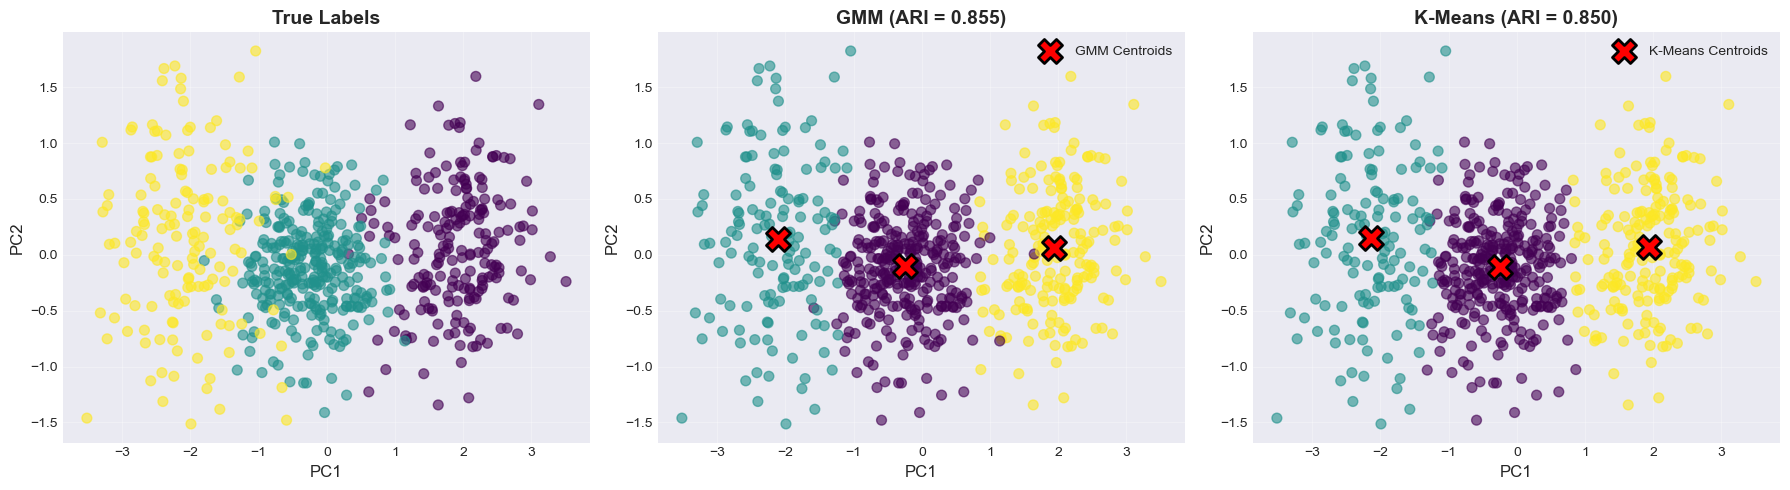

✓ GMM 與 K-Means 比較視覺化完成


In [12]:
# 視覺化 GMM 與 K-Means 的比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 真實標籤
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('True Labels', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. GMM 結果
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, cmap='viridis', alpha=0.6, s=50)
axes[1].scatter(means_pca[:, 0], means_pca[:, 1], 
                marker='X', s=300, c='red', edgecolors='black', 
                label='GMM Centroids', linewidths=2)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title(f'GMM (ARI = {ari_gmm:.3f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. K-Means 結果
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.6, s=50)
centers_kmeans_pca = pca.transform(kmeans.cluster_centers_)
axes[2].scatter(centers_kmeans_pca[:, 0], centers_kmeans_pca[:, 1], 
                marker='X', s=300, c='red', edgecolors='black', 
                label='K-Means Centroids', linewidths=2)
axes[2].set_xlabel('PC1', fontsize=12)
axes[2].set_ylabel('PC2', fontsize=12)
axes[2].set_title(f'K-Means (ARI = {ari_kmeans:.3f})', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '05_gmm_vs_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ GMM 與 K-Means 比較視覺化完成")

---
## 7. 化工應用：新產品品質預測與風險評估

### 7.1 模擬新產品數據並預測品質等級

In [13]:
# 模擬新產品數據 (配合新的數據分布)
np.random.seed(100)
n_new = 10

# 生成新產品數據 (配合新的品質區間分布)
X_new = np.array([
    [76, 86, 80],   # 應該接近 Premium
    [66, 76, 70],   # 應該接近 Standard
    [56, 66, 63],   # 應該接近 Substandard
    [72, 82, 76],   # 邊界案例：Standard/Premium
    [82, 90, 84],   # Premium
    [60, 70, 67],   # Standard/Substandard 邊界
    [68, 78, 72],   # Standard
    [74, 84, 78],   # Premium/Standard 邊界
    [62, 72, 68],   # Standard/Substandard 邊界
    [78, 88, 82]    # Premium
])

# 標準化新數據
X_new_scaled = scaler.transform(X_new)

# 預測群集標籤 (硬分群)
labels_new = gmm_best.predict(X_new_scaled)

# 預測機率 (軟分群)
proba_new = gmm_best.predict_proba(X_new_scaled)

# 建立結果 DataFrame
df_new = pd.DataFrame(X_new, columns=['Yield', 'Purity', 'Selectivity'])
df_new['Predicted_Cluster'] = labels_new
for i in range(best_K):
    df_new[f'P(Cluster_{i})'] = proba_new[:, i]

print("=" * 80)
print("新產品品質預測結果")
print("=" * 80)
print(df_new.to_string(index=True))
print("=" * 80)

新產品品質預測結果
   Yield  Purity  Selectivity  Predicted_Cluster  P(Cluster_0)  P(Cluster_1)  P(Cluster_2)
0     76      86           80                  2      0.004040  2.994467e-09  9.959601e-01
1     66      76           70                  0      0.978220  2.176648e-02  1.396418e-05
2     56      66           63                  1      0.000120  9.998795e-01  2.790265e-15
3     72      82           76                  0      0.775344  2.404865e-05  2.246324e-01
4     82      90           84                  2      0.000002  1.545159e-14  9.999977e-01
5     60      70           67                  1      0.047157  9.528435e-01  4.859387e-10
6     68      78           72                  0      0.997445  2.177127e-03  3.781014e-04
7     74      84           78                  2      0.107082  4.811382e-07  8.929180e-01
8     62      72           68                  1      0.367048  6.329518e-01  3.913726e-08
9     78      88           82                  2      0.000134  1.859593e-11  9.

### 7.2 風險評估與決策建議

In [14]:
# 風險評估與決策建議
def assess_quality_risk(proba, threshold_high=0.7, threshold_low=0.3):
    """
    根據機率評估品質風險
    
    Parameters:
    - proba: 屬於各群集的機率
    - threshold_high: 高信心閾值
    - threshold_low: 低信心閾值
    
    Returns:
    - risk_level: 風險等級
    - recommendation: 決策建議
    """
    max_proba = np.max(proba)
    pred_cluster = np.argmax(proba)
    
    if max_proba >= threshold_high:
        risk_level = "Low Risk"
        recommendation = f"High confidence: Product likely belongs to Cluster {pred_cluster}"
    elif max_proba >= threshold_low:
        risk_level = "Medium Risk"
        recommendation = f"Moderate confidence: Product may belong to Cluster {pred_cluster}, consider additional testing"
    else:
        risk_level = "High Risk"
        recommendation = "Low confidence: Product classification uncertain, recommend detailed quality inspection"
    
    return risk_level, recommendation

# 評估每個新產品
print("\n" + "=" * 100)
print("產品品質風險評估與決策建議")
print("=" * 100)

for i in range(len(X_new)):
    print(f"\n產品 #{i+1}:")
    print(f"  Yield: {X_new[i, 0]:.1f}%, Purity: {X_new[i, 1]:.1f}%, Selectivity: {X_new[i, 2]:.1f}%")
    print(f"  Predicted Cluster: {labels_new[i]}")
    print(f"  Probability Distribution: ", end="")
    for j in range(best_K):
        print(f"Cluster {j}: {proba_new[i, j]:.3f}  ", end="")
    print()
    
    risk_level, recommendation = assess_quality_risk(proba_new[i])
    print(f"  Risk Level: {risk_level}")
    print(f"  Recommendation: {recommendation}")
    print("-" * 100)

print("=" * 100)


產品品質風險評估與決策建議

產品 #1:
  Yield: 76.0%, Purity: 86.0%, Selectivity: 80.0%
  Predicted Cluster: 2
  Probability Distribution: Cluster 0: 0.004  Cluster 1: 0.000  Cluster 2: 0.996  
  Risk Level: Low Risk
  Recommendation: High confidence: Product likely belongs to Cluster 2
----------------------------------------------------------------------------------------------------

產品 #2:
  Yield: 66.0%, Purity: 76.0%, Selectivity: 70.0%
  Predicted Cluster: 0
  Probability Distribution: Cluster 0: 0.978  Cluster 1: 0.022  Cluster 2: 0.000  
  Risk Level: Low Risk
  Recommendation: High confidence: Product likely belongs to Cluster 0
----------------------------------------------------------------------------------------------------

產品 #3:
  Yield: 56.0%, Purity: 66.0%, Selectivity: 63.0%
  Predicted Cluster: 1
  Probability Distribution: Cluster 0: 0.000  Cluster 1: 1.000  Cluster 2: 0.000  
  Risk Level: Low Risk
  Recommendation: High confidence: Product likely belongs to Cluster 1
---------

---
## 8. 總結

### 8.1 GMM 模型關鍵特性

本 Notebook 展示了高斯混合模型 (GMM) 的核心特性與應用：

#### **1. 軟分群與機率評估**
- GMM 提供每個數據點屬於各群集的機率，而非硬性分配
- 適合處理群集邊界不明確的情況
- 支援不確定性量化，有助於風險評估

#### **2. 靈活的群集形狀**
- 透過協方差矩陣捕捉橢圓形群集
- 可以處理不同大小和方向的群集
- 比 K-Means 更靈活，適合非球形數據

#### **3. 模型選擇準則**
- 使用 BIC/AIC 等資訊準則選擇最佳群集數量
- 自動平衡模型複雜度與擬合度
- 結合多個評估指標確保模型品質

#### **4. 化工應用優勢**
- **品質分類**：識別優良品、合格品、次級品等品質等級
- **機率預測**：提供產品品質的機率評估，支援風險管理
- **決策支援**：根據機率分布提供操作建議
- **不確定性量化**：識別邊界模糊的產品，建議額外檢測

### 8.2 GMM vs K-Means 比較總結

| 特性 | GMM | K-Means |
|------|-----|---------|
| 分群類型 | 軟分群 (機率) | 硬分群 (確定性) |
| 群集形狀 | 橢圓形 | 球形 |
| 機率評估 | ✓ 提供 | ✗ 不提供 |
| 計算複雜度 | 較高 | 較低 |
| 適用場景 | 群集重疊、需要機率 | 群集分離明確 |
| 模型選擇 | BIC/AIC | 手肘法/輪廓係數 |

### 8.3 實務應用建議

1. **數據預處理**：務必進行特徵標準化
2. **K 值選擇**：優先使用 BIC，結合領域知識驗證
3. **協方差類型**：數據量充足時使用 `full`，數據量少時使用 `diag`
4. **多次初始化**：設定 `n_init >= 10` 確保穩定結果
5. **結果解釋**：結合硬分群與軟分群，提供全面的決策支援
6. **風險評估**：利用機率分布識別高風險產品

### 8.4 下一步學習

- 探索變分貝葉斯 GMM (Bayesian GMM) 自動確定群集數量
- 結合 GMM 與降維方法 (PCA, UMAP) 處理高維數據
- 應用 GMM 於異常檢測與製程監控
- 學習 GMM 在時間序列數據中的應用 (結合 HMM)

---

**✓ Unit05 高斯混合模型 (GMM) 課程完成！**